In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import Sequence
from keras.preprocessing.sequence import TimeseriesGenerator


from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Input, Flatten, Dropout

from statsmodels.tools.eval_measures import rmse


from tabulate import tabulate


import numpy as np,array
import time 

Using TensorFlow backend.


# Notes 

This notebook investigates which type of LSTM works best for our model: Vanilla, Stacked, or Bidirectional 
    
    
1. Preprocessing 
2. Predict China's Confirmed Cases   
&nbsp;&nbsp; 2.1 Apply Vanilla LSTM   
&nbsp;&nbsp; 2.2 Apply Stacked LSTM     
&nbsp;&nbsp; 2.1 Apply Bidirectional LSTM    
3. Discussion on Results


In [2]:
covid = pd.read_csv('../data/corona-virus-report/covid_19_clean_complete.csv')

We want to see what our data looks like:

In [3]:
covid.head(15)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2.0,0.0,0.0
1,NaN,Japan,36.0000,138.0000,1/22/20,2.0,0.0,0.0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0.0,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0.0,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0.0,0.0,0.0
5,British Columbia,Canada,49.2827,-123.1207,1/22/20,0.0,0.0,0.0
6,New South Wales,Australia,-33.8688,151.2093,1/22/20,0.0,0.0,0.0
7,Victoria,Australia,-37.8136,144.9631,1/22/20,0.0,0.0,0.0
8,Queensland,Australia,-28.0167,153.4000,1/22/20,0.0,0.0,0.0
9,NaN,Cambodia,11.5500,104.9167,1/22/20,0.0,0.0,0.0


## 1. Pre-processing
We want to isolate our data to find: Country, Date, and Confirmed Cases 

In [4]:
covid = covid[['Country/Region', 'Date', 'Confirmed']]

Let's see how the US is doing 

In [5]:
US = covid.loc[covid['Country/Region'] == "US"]
US

,Country/Region,Date,Confirmed
98,US,1/22/20,0.0
99,US,1/22/20,0.0
100,US,1/22/20,0.0
101,US,1/22/20,0.0
102,US,1/22/20,0.0
...,...,...,...
19136,US,3/23/20,23.0
19150,US,3/23/20,27.0
19167,US,3/23/20,NaN
19210,US,3/23/20,6.0


We notice that by isolating rows with Country/Region == US, we will end up with multiple rows with the same date. This is because this dataset is reporting different states as well. What we want to do is sum up all "Confirmed" values based on grouped dates. 

Also we need to convert the Date column from str to datetime in order to sort 

In [6]:
US[['Date']] = US['Date'].apply(pd.to_datetime)

In [7]:
col = ["Country/Region","Date"]
US = US.groupby(col, as_index=False).Confirmed.sum()

In [8]:
US = US.sort_values(['Date'], ascending=[True])

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(US)

   Country/Region       Date  Confirmed
0              US 2020-01-22        0.0
1              US 2020-01-23        0.0
2              US 2020-01-24        0.0
3              US 2020-01-25        0.0
4              US 2020-01-26        0.0
5              US 2020-01-27        0.0
6              US 2020-01-28        0.0
7              US 2020-01-29        0.0
8              US 2020-01-30        0.0
9              US 2020-01-31        0.0
10             US 2020-02-01        0.0
11             US 2020-02-02        0.0
12             US 2020-02-03        0.0
13             US 2020-02-04        0.0
14             US 2020-02-05        0.0
15             US 2020-02-06        0.0
16             US 2020-02-07        0.0
17             US 2020-02-08        0.0
18             US 2020-02-09        0.0
19             US 2020-02-10        0.0
20             US 2020-02-11        0.0
21             US 2020-02-12        0.0
22             US 2020-02-13        0.0
23             US 2020-02-14        0.0


Since not all countries will "line" up with each other in terms of dates, let's set a mark where we only start looking after the 10th or so confirmed case 

In [10]:
US = US.loc[US["Confirmed"] > 10.0] 
US

,Country/Region,Date,Confirmed
33,US,2020-02-24,36.0
34,US,2020-02-25,36.0
35,US,2020-02-26,42.0
36,US,2020-02-27,42.0
37,US,2020-02-28,44.0
38,US,2020-02-29,44.0
39,US,2020-03-01,44.0
40,US,2020-03-02,45.0
41,US,2020-03-03,45.0
42,US,2020-03-04,45.0


Now we should reset the index, so that it now counts the days after the first 10th confirmed case. This will help lining up all countries together 

In [11]:
US = US.reset_index(drop=True)
US

,Country/Region,Date,Confirmed
0,US,2020-02-24,36.0
1,US,2020-02-25,36.0
2,US,2020-02-26,42.0
3,US,2020-02-27,42.0
4,US,2020-02-28,44.0
5,US,2020-02-29,44.0
6,US,2020-03-01,44.0
7,US,2020-03-02,45.0
8,US,2020-03-03,45.0
9,US,2020-03-04,45.0


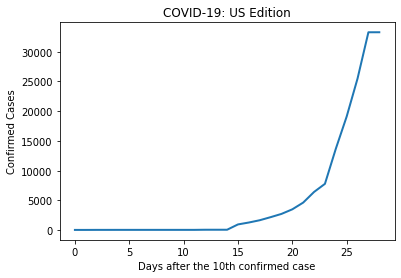

In [12]:
plt.plot(US.index, US['Confirmed'], linewidth = 2)
plt.title("COVID-19: US Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.show()

We should focus on 3 main countries for now 

In [13]:
all_countries = list(covid["Country/Region"].unique())
all_countries 

['Thailand',
 'Japan',
 'Singapore',
 'Nepal',
 'Malaysia',
 'Canada',
 'Australia',
 'Cambodia',
 'Sri Lanka',
 'Germany',
 'Finland',
 'United Arab Emirates',
 'Philippines',
 'India',
 'Italy',
 'Sweden',
 'Spain',
 'Belgium',
 'Egypt',
 'Lebanon',
 'Iraq',
 'Oman',
 'Afghanistan',
 'Bahrain',
 'Kuwait',
 'Algeria',
 'Croatia',
 'Switzerland',
 'Austria',
 'Israel',
 'Pakistan',
 'Brazil',
 'Georgia',
 'Greece',
 'North Macedonia',
 'Norway',
 'Romania',
 'Estonia',
 'San Marino',
 'Belarus',
 'Iceland',
 'Lithuania',
 'Mexico',
 'New Zealand',
 'Nigeria',
 'Ireland',
 'Luxembourg',
 'Monaco',
 'Qatar',
 'Ecuador',
 'Azerbaijan',
 'Armenia',
 'Dominican Republic',
 'Indonesia',
 'Portugal',
 'Andorra',
 'Latvia',
 'Morocco',
 'Saudi Arabia',
 'Senegal',
 'Argentina',
 'Chile',
 'Jordan',
 'Ukraine',
 'Hungary',
 'Liechtenstein',
 'Poland',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Slovenia',
 'South Africa',
 'Bhutan',
 'Cameroon',
 'Colombia',
 'Costa Rica',
 'Peru',
 'Serbia',
 'Sl

In [14]:
china = covid.loc[covid['Country/Region'] == "China"]
china[['Date']] = china['Date'].apply(pd.to_datetime)
china = china.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
china = china.groupby(col, as_index=False).Confirmed.sum()
china = china.loc[china["Confirmed"] > 10.0] 
china = china.reset_index(drop=True)


italy = covid.loc[covid['Country/Region'] == "Italy"]
italy[['Date']] = italy['Date'].apply(pd.to_datetime)
italy = italy.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
italy = italy.groupby(col, as_index=False).Confirmed.sum()
italy = italy.loc[italy["Confirmed"] > 10.0] 
italy = italy.reset_index(drop=True)

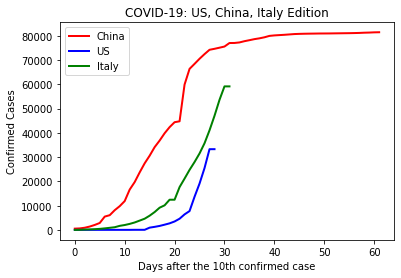

In [15]:
plt.plot(china.index, china['Confirmed'], 'r', linewidth = 2, label="China")
plt.plot(US.index, US['Confirmed'],'b',linewidth = 2, label="US")
plt.plot(italy.index, italy['Confirmed'],'g',linewidth = 2, label="Italy")
plt.title("COVID-19: US, China, Italy Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

Moving forward, you can call "US", "Italy", or "China" to work for either country

## 1.2 Let's focus on China 

In [16]:
china_train = china[["Confirmed"]]

In [17]:
china_train

,Confirmed
0,548.0
1,643.0
2,920.0
3,1406.0
4,2075.0
...,...
57,81156.0
58,81250.0
59,81305.0
60,81397.0


## 2. Predict China's Confirmed Cases

In [18]:
china = china[["Date", "Confirmed"]]

In [19]:
china.Date = pd.to_datetime(china.Date)

In [20]:
china = china.set_index("Date")

In [21]:
train_data = china[:len(china)-3]
test_data = china[len(china)-3:]

In [22]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [23]:
steps = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=steps, batch_size=1)

### 2.1 Apply Vanilla LSTM

Apply a Vanilla LSTM (single layer of LSTM units and output layer for prediction) 

In [24]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [26]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
56/56 [==============================] - 1s 12ms/step - loss: 0.2095
Epoch 2/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 3/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 0.002 - 1s 9ms/step - loss: 0.0024
Epoch 5/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 6/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 8/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 9/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 10/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 11/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 12/20
56/56 [==============================] - 0s 

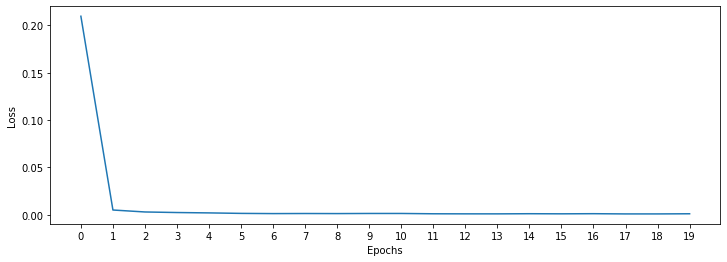

In [27]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [28]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-steps:]
current_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [29]:
lstm_predictions_scaled

[array([1.00415], dtype=float32),
 array([1.0055352], dtype=float32),
 array([1.007232], dtype=float32)]

In [30]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[81584.91596293],
       [81696.70533729],
       [81833.63289022]])

In [31]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2020-03-21,81305.0,81584.915963
2020-03-22,81397.0,81696.705337
2020-03-23,81439.0,81833.632890


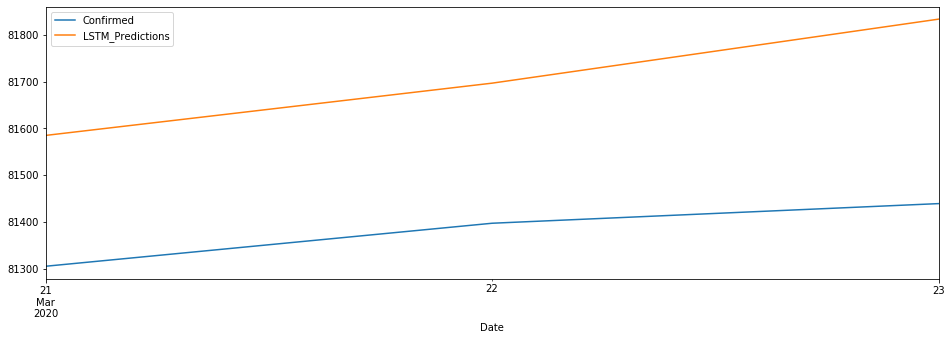

In [32]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [33]:
lstm_rmse_error_vanilla = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_vanilla = lstm_rmse_error_vanilla**2
mean_value = china['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_vanilla, '\nRMSE Error:', lstm_rmse_error_vanilla, '\nMean:',mean_value)

MSE Error: 107970.45118339793 
RMSE Error: 328.5885743348328 
Mean: 56954.33870967742


---
### 2.2 Apply Stacked LSTM 

What is stacked LSTM? 
Multiple Hidden LSTM layers can be stacked one on top of another. 

In [34]:
lstm_model = Sequential()

# (bs, 3, 1 ) 
lstm_model.add(LSTM(200, activation='relu', return_sequences = True, input_shape=(steps, n_features)))

# (bs, 3, 1 ) Second Hidden layer requires 3 dimensions, call return_sequences = True from input layer 
lstm_model.add(LSTM(200, activation='relu'))

lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [35]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 200)            161600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


In [36]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
56/56 [==============================] - 1s 19ms/step - loss: 0.1842
Epoch 2/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 3/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0029
Epoch 4/20
56/56 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 5/20
56/56 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6/20
56/56 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 7/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 9/20
56/56 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 10/20
56/56 [==============================] - 1s 10ms/step - loss: 0.0016
Epoch 11/20
56/56 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 12/20
56/56 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 13/20
56/56 [=========================

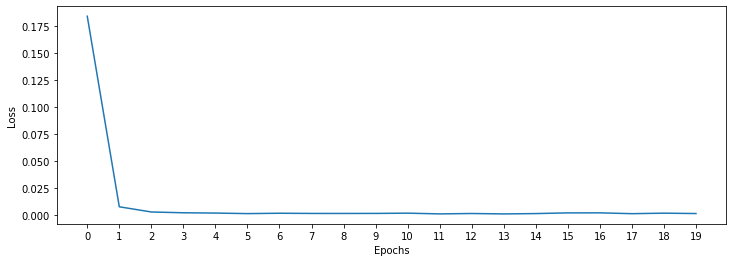

In [37]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [38]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-steps:]
current_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [39]:
lstm_predictions_scaled

[array([1.0355932], dtype=float32),
 array([1.0402974], dtype=float32),
 array([1.0498148], dtype=float32)]

In [40]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[84122.43855643],
       [84502.07988954],
       [85270.15562701]])

In [41]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2020-03-21,81305.0,84122.438556
2020-03-22,81397.0,84502.079890
2020-03-23,81439.0,85270.155627


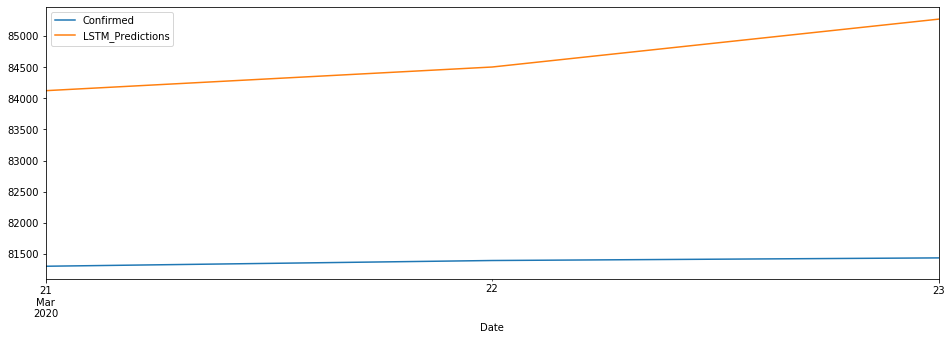

In [42]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [43]:
lstm_rmse_error_stacked = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_stacked = lstm_rmse_error_stacked**2
mean_value = china['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_stacked, '\nRMSE Error:', lstm_rmse_error_stacked, '\nMean:',mean_value)

MSE Error: 10752411.526020648 
RMSE Error: 3279.086995799387 
Mean: 56954.33870967742


---
### 2.3 Apply Bidirectional LSTM 
What is Bidirectional LSTM? 
Bidirectional LSTM is an extension of traditional LSTM. Bidirectional LSTM trains two instead of one LSTM on the input sequence. In other words, one input is from past to future and the other from future to past 


In [44]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(steps, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [45]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 400)               323200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 323,601
Trainable params: 323,601
Non-trainable params: 0
_________________________________________________________________


In [46]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
56/56 [==============================] - 1s 17ms/step - loss: 0.1416
Epoch 2/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 3/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 4/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 5/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 6/20
56/56 [==============================] - 0s 8ms/step - loss: 9.6756e-04
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 9/20
56/56 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 11/20
56/56 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 12/20
56/56 [==============================] - 0s 7ms/step - loss: 9.3541e-04
Epoch 13/20
56/56 [=====================

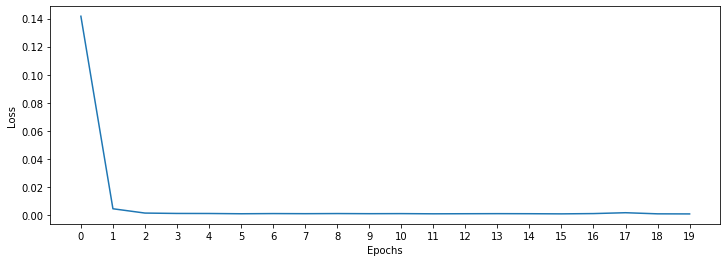

In [47]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [48]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-steps:]
current_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [49]:
lstm_predictions_scaled

[array([1.0133452], dtype=float32),
 array([1.0176389], dtype=float32),
 array([1.0225577], dtype=float32)]

In [50]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[82326.9876833 ],
       [82673.49626207],
       [83070.45436573]])

In [51]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2020-03-21,81305.0,82326.987683
2020-03-22,81397.0,82673.496262
2020-03-23,81439.0,83070.454366


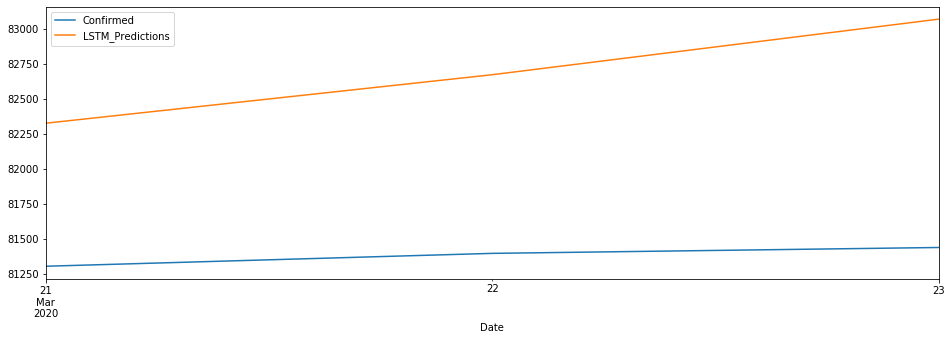

In [52]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [53]:
lstm_rmse_error_bd = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_bd = lstm_rmse_error_bd**2
mean_value = china['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_bd, '\nRMSE Error:', lstm_rmse_error_bd, '\nMean:',mean_value)

MSE Error: 1778514.9597857753 
RMSE Error: 1333.6097479344455 
Mean: 56954.33870967742


In [54]:
print(tabulate([
    ['Vanilla LSTM', lstm_mse_error_vanilla, lstm_rmse_error_vanilla], 
    ['Stacked LSTM', lstm_mse_error_stacked, lstm_rmse_error_stacked],
    ['Bidirectional LSTM', lstm_mse_error_bd, lstm_rmse_error_bd]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))




Model                            MSE      RMSE
------------------  ----------------  --------
Vanilla LSTM        107970             328.589
Stacked LSTM             1.07524e+07  3279.09
Bidirectional LSTM       1.77851e+06  1333.61


## Discussion 
Interestingly enough, Vanilla LSTM gives us the lowest RMSE error